# CS224 - Spring 2024 - HW1 - Joy-o-Meter

Submit **PDF** of completed IPython notebook on Canvas

**Due**: February 1, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: quiet
  </br>
  <b>Student ID Number</b>:  
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment you will implement a simple linear neural network that reads in text and uses pretrained embeddings to predict the **happiness intensity** of the text.
You'll fit the network weights using the analytic expression we discussed in class.

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, "pandas" for data loading, matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the code marked `TODO` and print desired results.

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## **Getting and processing data [2 points]**
You can download the two data files here:
https://elearn.ucr.edu/files/11510987/download?download_frd=1
https://elearn.ucr.edu/files/11510996/download?download_frd=1
You'll have to make them available locally or upload them to your colab instance.

In [ ]:
# Load dataset and visualize
train_file = 'https://drive.google.com/uc?id=19xVpUgCFP4xZifXrNxigT5XL83cmcXws'
val_file = 'https://drive.google.com/uc?id=1ugBTdnVqlHTqh_y_PLNRAXxOU1rqpciI'
# train_file = 'EI-reg-En-joy-train.txt'
# val_file = '2018-EI-reg-En-joy-dev.txt'
df_train = pd.read_csv(train_file, sep='\t')
df_val = pd.read_csv(val_file, sep='\t')

tweets_train = df_train['Tweet'].tolist()  # Create a list of tweets
tweets_val = df_val['Tweet'].tolist()

# Create a list of intensity scores
y_train = torch.tensor(df_train['Intensity Score'], dtype=torch.float32)  # match to dtype of embedding
y_val = torch.tensor(df_val['Intensity Score'], dtype=torch.float32)

# print(df_train.head)
# print(df_val.head)
print('Score - Tweet')
for i in range(5):
    print('{:0.2f} - {}'.format(y_train[i], tweets_train[i]))

Score - Tweet
0.14 - @david_garrett Quite saddened.....no US dates, no joyous anticipation of attending a DG concert (since 2014). Happy you are keeping busy.
0.79 - 2 days until #GoPackGo and 23 days until #GoGipeGo..... I'm so excited! 
0.27 - Positive #psychology research shows salespeople who score in the top 10% for #optimism have 88% &gt; sales than those in top 10% for pessimism.
0.48 - As the birds chirp and the cows moo we need to listen to the sound of nature to ensure that all is well.
0.94 - Howling with laughter at “WELL DONE BEZZA!” #bakeoff #GBBO


In [ ]:
# TODO [1 point]: load a pretrained model and write a function that embeds sentences into vector space
# Use the approach shown in Jan. 19 class (or improve on it)

model="bert-base-uncased"  # Many possibilities on huggingface.com
# Load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained(model)
bertmodel=AutoModel.from_pretrained(model)

# Load pre-trained model
def embed_sentence(model, tokenizer, sentence):
    """Function to embed a sentence as a vector using a pre-trained model."""
    token_ids = tokenizer(sentence).input_ids

    # Forward pass, get hidden states
    with torch.no_grad():
        embeddings = model(torch.tensor(token_ids).unsqueeze(0)).last_hidden_state.mean(dim=1)

    # For BERT, last hidden state is the embedding of each item in the sequence
    return embeddings  # use mean embedding, for hw
    # return outputs.last_hidden_state[0, 0]  # use CLS embedding, another good choice
    # return

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# TODO [1 point]: Use embed_sentence to turn text into a matrix of embeddings.
# Create a pytorch matrix where each row corresponds to a tweet,
# and the number of columns/features is the size of the embedding
# (Obviously one for train and one for validation)
# For me, on the CPU of my laptop, it took about a minute or two to do the processing

X_train = torch.randn((len(y_train), 768))  # Delete and replace placeholder
X_val = torch.randn((len(y_val), 768))  # Delete and replace placeholder

for i, tweet in enumerate(tweets_train):
  embedding = embed_sentence(bertmodel,tokenizer, tweet)
  X_train[i] = embedding

for i, tweet in enumerate(tweets_val):
  embedding = embed_sentence(bertmodel, tokenizer, tweet)
  X_val[i] = embedding

# X_train_tensor = torch.tensor(X_train)
# X_val_tensor = torch.tensor(X_val)

# X_train_tensor = [embed_sentence(bertmodel, tokenizer, tweet) for tweet in tweets_train]
# X_val_tensor = [embed_sentence(bertmodel, tokenizer, tweet) for tweet in tweets_val]

print(X_train.shape, X_val.shape)

torch.Size([1616, 768]) torch.Size([290, 768])


## Define the model [5 points]

In [ ]:
class MyLinearNet(torch.nn.Module):
    def __init__(self, embedding_size):
        super().__init__()  # init superclass - enables many pytorch model capabilities
        self.d = embedding_size  # Often convenient to store this (not a "Parameter" though as we don't train it)
        # TODO [1 point]: define weights and bias parameters
        self.weights = torch.nn.Parameter(torch.randn(embedding_size, 1))  # Assuming output size is 1 for simplicity
        self.bias = torch.nn.Parameter(torch.randn(1))

    def forward(self, x):
        """Implement a linear model"""
        # TODO [1 point]: implement linear model, in terms of weights and biases
        # It should work on a single x, or a batch
        y_hat = torch.ones(len(x))  # This gives a constant prediction - delete when you implement your method
        y_hat = torch.matmul(x, self.weights) + self.bias
        #print(len(x))
        return y_hat

    def fit(self, X, y):
      """Given a data matrix, X, and a vector of labels for each row, y,
      analytically fit the parameters of the linear model."""
      # TODO [3 points]: Use linear regression formula to set weight and bias parameters

      # (a) First, construct the augmented data matrix as discussed in class
      X_augmented = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)

      # (b) Next, use matrix multiplication and torch.linalg.inv to implement the analytic solution
      X_transposed = X_augmented.t()
      XTX_inverse = torch.linalg.pinv(torch.matmul(X_transposed, X_augmented))
      w = torch.matmul(torch.matmul(XTX_inverse, X_transposed), y)

      # (c) Put the solution (which includes weights and biases) into parameters
      # Use "data" to update parameters without affecting the computation graph
      self.weights.data = w[:-1]
      self.bias.data = w[-1]



## Results [8 points]

In [ ]:
def loss(model, X, y):
    # TODO [1 point]: implement the mean square error loss
    y_pred = model(X)
    mse_loss = torch.nn.functional.mse_loss(y_pred, y)
    return mse_loss.item()

d = X_train.shape[1]  # embedding dimension
model = MyLinearNet(d)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation BEFORE fitting.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

model.fit(X_train, y_train)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)

# TODO [5 points]: Show that Train loss is reduced below 0.02
# and Validation loss is reduced below 0.05, at least

print("\nLoss on train and validation AFTER fitting.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))


<ipython-input-6-3c6d34e588ed>:4: UserWarning: Using a target size (torch.Size([1616])) that is different to the input size (torch.Size([1616, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = torch.nn.functional.mse_loss(y_pred, y)
<ipython-input-6-3c6d34e588ed>:4: UserWarning: Using a target size (torch.Size([290])) that is different to the input size (torch.Size([290, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = torch.nn.functional.mse_loss(y_pred, y)



Loss on train and validation BEFORE fitting.
Train: 143.798, Val: 158.632

Loss on train and validation AFTER fitting.
Train: 0.014, Val: 0.025


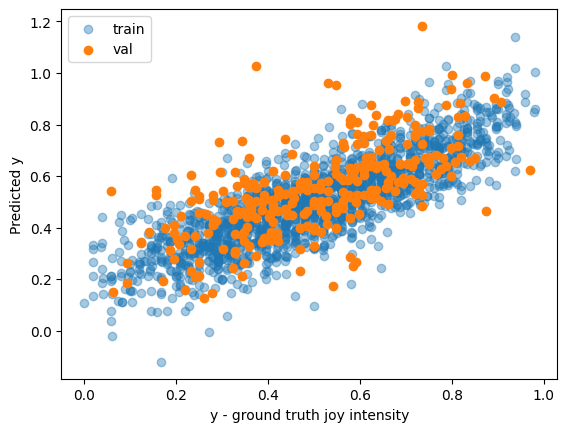

In [ ]:
# Assuming X_train, y_train, X_val, y_val, model are already defined
# and model is already trained

with torch.no_grad():
    y_hat_train = model(X_train)
    y_hat_val = model(X_val)

def plot(y_train, y_hat_train, y_val, y_hat_val):
    """Create a scatter plot of actual vs. predicted values of `y`."""
    fig, ax = plt.subplots(1)
    ax.scatter(y_train, y_hat_train, alpha=0.4, label='train')
    ax.scatter(y_val, y_hat_val, label='val')
    ax.set_xlabel('y - ground truth joy intensity')
    ax.set_ylabel('Predicted y')
    ax.legend()

# Plot actual vs. predicted values for both training and validation sets
plot(y_train, y_hat_train, y_val, y_hat_val)
plt.show()

In [ ]:
# TODO [1 point]  Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
happy = "I am never happier than when I'm doing homework :) LOL"
sad = "I am so tired of homework right now"

y_hat_happy = model(embed_sentence(bertmodel,tokenizer,happy))[0]
y_hat_sad = model(embed_sentence(bertmodel,tokenizer,sad))[0]

#print(y_hat_happy)
print('{:0.2f} - {}'.format(y_hat_happy, happy))
print('{:0.2f} - {}'.format(y_hat_sad, sad))

0.66 - I am never happier than when I'm doing homework :) LOL
0.12 - I am so tired of homework right now


## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point.
- Compare multiple embedding methods. For instance, I'd look at a contrastive method like
princeton-nlp/unsup-simcse-bert-base-uncased or sentence-transformers/all-mpnet-base-v2 and a CLIP variant (trained on text and images). I hypothesize the contrastive methods will be better than CLIP for this task (which is not a visual task). You could also try a GPT model embedding, but while they are great at generation the embeddings are typically not useful for other tasks.
- Work ahead and try putting in a multi-layer MLP and training with SGD. How much can you improve the validation loss?
- Compare different strategies for extracting BERT embeddings: instead of using the mean embedding like I showed in class, compare to the embedding from the first token (to make this work better, people sometimes prepend the sentence with a special [cls] token before tokenizing).

# Extra Credit - CLS embedding

<ipython-input-13-3be5048f046f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cls_embedding = model(torch.tensor(token_ids_cls)).last_hidden_state[:, 0, :]



Loss on train and validation AFTER fitting with CLS embedding.
Train: 0.019, Val: 0.023


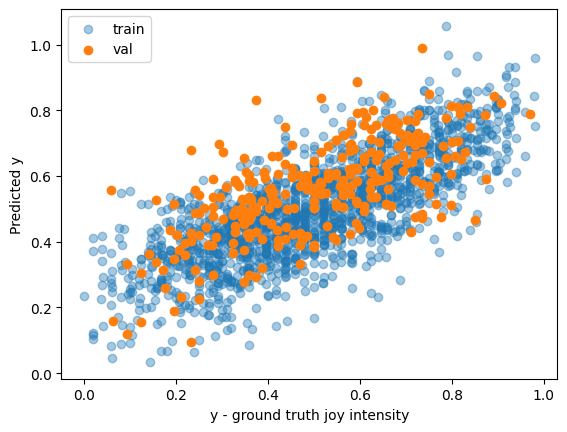

In [ ]:
model="bert-base-uncased"  # Many possibilities on huggingface.com
# Load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained(model)
bertmodel=AutoModel.from_pretrained(model)

def embed_sentence_cls(model, tokenizer, sentence):
    """Function to embed a sentence as a vector using a pre-trained model."""
    # Prepend [CLS] token to the sentence before tokenizing
    sentence_with_cls = "[CLS] " + sentence

    # Tokenize the input sentence and convert tokens to tensor
    token_ids_cls = tokenizer(sentence_with_cls, return_tensors="pt").input_ids

    with torch.no_grad():
        cls_embedding = model(torch.tensor(token_ids_cls)).last_hidden_state[:, 0, :]

    return cls_embedding

X_train_cls = torch.randn((len(y_train), 768))
X_val_cls = torch.randn((len(y_val), 768))

for i, tweet in enumerate(tweets_train):
  embedding = embed_sentence_cls(bertmodel,tokenizer, tweet)
  X_train_cls[i] = embedding

for i, tweet in enumerate(tweets_val):
  embedding = embed_sentence_cls(bertmodel, tokenizer, tweet)
  X_val_cls[i] = embedding

model_cls = MyLinearNet(d)
model_cls.fit(X_train_cls, y_train)

loss_train_cls = loss(model_cls, X_train_cls, y_train)
loss_val_cls = loss(model_cls, X_val_cls, y_val)

print("\nLoss on train and validation AFTER fitting with CLS embedding.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train_cls, loss_val_cls))

with torch.no_grad():
    y_hat_train_cls = model_cls(X_train_cls)
    y_hat_val_cls = model_cls(X_val_cls)

plot(y_train, y_hat_train_cls, y_val, y_hat_val_cls)
plt.show()


In [ ]:
# TODO [1 point]  Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
happy = "I am never happier than when I'm doing homework :) LOL"
sad = "I am so tired of homework right now"

y_hat_happy = model_cls(embed_sentence_cls(bertmodel,tokenizer,happy))[0]
y_hat_sad = model_cls(embed_sentence_cls(bertmodel,tokenizer,sad))[0]

#print(y_hat_happy)
print('{:0.2f} - {}'.format(y_hat_happy, happy))
print('{:0.2f} - {}'.format(y_hat_sad, sad))

<ipython-input-13-3be5048f046f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cls_embedding = model(torch.tensor(token_ids_cls)).last_hidden_state[:, 0, :]


0.55 - I am never happier than when I'm doing homework :) LOL
0.24 - I am so tired of homework right now
